# Manuscript methods

This notebook contains the code used to conduct the analysis presented in the linked manuscript.

For any questions, please contact the corresponding author on the manuscript.

In [58]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1 – Setup

## 1.1 – Load data

Separately, we organized the OpenWillis output to create the dataframe we will be using in this analysis.

In [31]:
df = pd.read_csv('24-02-08 KAR-004 dataframe, PANSS.csv')

## 1.2 – Defining functions

In this section, we are defining all functions that we will be using throughout the analysis. It contains most of the code in this notebook.

**Plot distribution**

This function, `distribution`, visualizes the distribution of a specified variable from a given DataFrame. It starts by removing any missing values from the selected variable, then calculates its mean, standard deviation, and kurtosis. Depending on the `plot_type` specified, it creates either a density plot or a histogram to showcase the distribution, annotating the plot with the variable's mean, standard deviation, and kurtosis, along with the sample size.

In [32]:
def distribution(df, var, var_name, plot_type):
    
    # first, exclude any nans
    data = df[var].dropna()
    
    # get mean and std
    data_mean = data.mean()
    data_std = data.std()
    data_kurt = stats.kurtosis(data)
    
    # start plot
    plt.figure(figsize=(3.3, 3.7))

    # create density plot
    if plot_type == 'density plot':
        sns.kdeplot(data, color='#2E822D', fill=True)
    else:
        plt.hist(data, bins=10, color='#b8d4b4', edgecolor='black')
    
    # make the plot
    string = f'$\mu$ = {data_mean:.1f}; $\sigma$ = {data_std:.1f}\n$Kurtosis$ = {data_kurt:.1f}'
    plt.title(f"{var_name}\n{string}", pad=10)
    plt.ylabel('Density' if plot_type == 'density plot' else 'Frequency')
    plt.xlabel(f'n = {len(data)}')
    plt.tight_layout()
    plt.show()
    

**Plot boxplot with t-test**

The function `boxplot_ttest` performs a t-test between two groups and then visualizes the results using a boxplot. Initially, it calculates the t-statistic and p-value to compare the means of `group1` and `group2`. If the p-value is less than a predefined threshold (`pval_thresh`), it creates a boxplot with the data from both groups, highlighting the difference in their distributions. The boxplot includes notches and mean lines for a clearer visual representation of the data's central tendency and variance, and it's annotated with the p-value and sample sizes for each group.

In [33]:
def boxplot_ttest(df, var_name, group1, group2, label1, label2, pval_thresh):
    
    # perform t-test
    t_stat, pval = stats.ttest_ind(group1, group2)
    
    # combine data into single df
    data_to_plot = [group1, group2]
    
    if pval < pval_thresh:
        
        # start plot
        fig, ax = plt.subplots(figsize=(3.3, 3.7))
        plt.gca().set_facecolor('#f5f5f5'if pval > 0.05 else 'white')
        bp = ax.boxplot(data_to_plot, patch_artist=True, notch=True, showmeans=True, meanline=True)
        colors = ['#5D9B5C', '#B0D2B0']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        ax.set_title(f'{var_name}\np-val: {pval:.2f}', pad=10)
        ax.set_ylabel(var_name)
        ax.set_xticklabels([f'{label1}\nn={len(group1)}', f'{label2}\nn={len(group2)}'])    
        plt.tight_layout()
        plt.show()


**Plot scatterplot with Pearson correlation**

The function `scatterplot_corr` generates a scatter plot to illustrate the correlation between a dependent variable and an independent variable from a given DataFrame. It first filters out rows with missing values for these variables and then computes Pearson's correlation coefficient and p-value to assess the strength and significance of their linear relationship. If the p-value is below a specified threshold (`pval_thresh`), a scatter plot is created using seaborn's `regplot`, which includes a regression line to depict the correlation. The plot is annotated with the coefficient of determination (R²), p-value, and the number of data points, providing a visual and quantitative understanding of the relationship between the two variables.

In [34]:
def scatterplot_corr(df, dep_var, ind_var, dep_var_label, ind_var_label, title, pval_thresh):
    
    # get only columns we need
    df_plot = df.dropna(subset=[dep_var, ind_var]).copy()
    
    # extract age and measure data
    dep_var_data = df_plot[dep_var]
    ind_var_data = df_plot[ind_var]
    
    # conduct pearson correlation
    r_value, pval = stats.pearsonr(dep_var_data, ind_var_data)
    rsq = r_value ** 2
    
    if pval < pval_thresh: 
        
        # make plot
        plt.figure(figsize=(3.3, 3.7))
        plt.gca().set_facecolor('#f5f5f5'if pval > 0.05 else 'white')
        sns.regplot(x=df_plot[dep_var], y=df_plot[ind_var], scatter_kws={'color': '#b8d4b4', 'alpha': 0.5}, line_kws={'color': 'darkgreen'})
        
        plt.title(f"{title}\n $R^2$ = {rsq:.3f}; p-value = {pval:.3f}\n n = {len(df_plot)}", pad=10)
        plt.ylabel(ind_var_label)
        plt.xlabel(dep_var_label)
        plt.tight_layout()
        plt.show()
    

**Plot scatterplot with multiple linear regression**

The function `scatterplot_mlr` generates a scatter plot to visualize and evaluate the relationship between a specific independent variable and a dependent variable within a multiple linear regression model that includes other covariates. It filters the data to remove missing values, fits the model, and if the relationship is statistically significant based on the p-value, it creates a plot. This plot shows the independent variable against the dependent variable, annotated with the coefficient and p-value to highlight the strength and significance of their relationship in the context of the multivariate model.

In [35]:
def scatterplot_mlr(df, dep_var, ind_var, dep_var_label, ind_var_label, pval_thresh):
    
    # get only columns we need
    df_plot = df.dropna(subset=[dep_var, 'age', 'male', 'female', 'white', 'black', ind_var]).copy()
    
    # run model
    X = df_plot[[ind_var, 'age', 'male', 'female', 'white', 'black']]
    X = sm.add_constant(X)
    y = df_plot[dep_var]
    model = sm.OLS(y, X).fit()
    
    # get results
    pval = model.pvalues[ind_var]
    coef = model.params[ind_var]
    
    if pval < pval_thresh: 

        # create plot, with dep / ind axes switched
        plt.figure(figsize=(3.3, 3.7))
        ax = plt.gca()
        ax.set_facecolor('#f5f5f5'if pval > 0.05 else 'white')
        sns.regplot(x=df_plot[dep_var], y=df_plot[ind_var], scatter_kws={'color': '#b8d4b4', 'alpha': 0.5}, line_kws={'color': 'darkgreen'})
        plt.title(f"{ind_var_label}\ncoef = {coef:.3f}; p-value = {pval:.3f}\n n = {len(df_plot)}", pad=10)
        plt.ylabel(ind_var_label)
        plt.xlabel(dep_var_label)
        plt.tight_layout()
        plt.show()

        print(model.summary())
    

# 2 – Study data

Here, we are gathering some basic statistics on the study data to inform our analysis.

In [36]:
# creating a dataframe that has data from screening only
df_screening = df[df['visit'] == 1].drop_duplicates(subset='id', keep='first')

**Age**

Printing out the min, max, mean, and median age of the participants

In [37]:
# descriptive statistics for age
print(f"min age: {df['age'].min()}")
print(f"max age: {df['age'].max()}")
print(f"mean age: {df['age'].mean()}")
print(f"median age: {df['age'].median()}")

min age: 19.0
max age: 60.0
mean age: 42.84004739336493
median age: 44.0


Plotting the relationship between PANSS overall scores and age

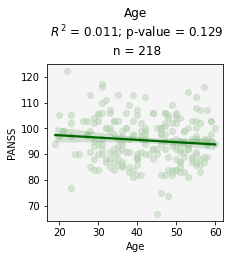

In [38]:
# plotting age against panss scores
scatterplot_corr(df_screening, 'age', 'panss', 'Age', 'PANSS', 'Age', 1)

**Sex**

Printing out the _n_ we have for each sex

In [39]:
# descriptive statistics for sex
print(f"male: { df[df['male'] == 1]['id'].nunique()}")
print(f"female: {df[df['female'] == 1]['id'].nunique()}")

male: 165
female: 53


Plotting the difference in PANSS overall score by sex

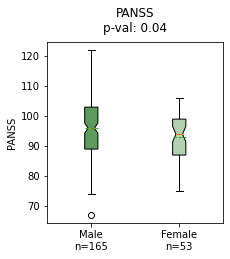

In [40]:
# comparing panss scores between male / female patients
male = df_screening[df_screening['male'] == 1]['panss'].dropna()
female = df_screening[df_screening['female'] == 1]['panss'].dropna()
boxplot_ttest(df_screening, 'PANSS', male, female, 'Male', 'Female', 1)

**Race**

Printing out the _n_ we have for each race

In [41]:
# descriptive statistics for race
print(f"white: { df[df['white'] == 1]['id'].nunique()}")
print(f"black: {df[df['black'] == 1]['id'].nunique()}")

white: 47
black: 171


Plotting the difference in PANSS overall score by race

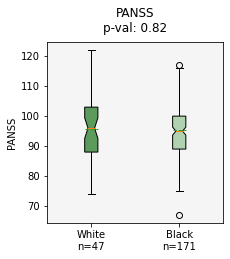

In [42]:
# comparing panss scores between white / black patients
white = df_screening[df_screening['white'] == 1]['panss'].dropna()
black = df_screening[df_screening['black'] == 1]['panss'].dropna()    
boxplot_ttest(df_screening, 'PANSS', white, black, 'White', 'Black', 1)

**Visits**

Printing out how much data we have for each visit

In [43]:
# counting the number of entries for each visit
print(f"screening: { df[df['visit'] == 1]['id'].nunique()}")
print(f"baseline: { df[df['visit'] == 2]['id'].nunique()}")
print(f"day 7: { df[df['visit'] == 4]['id'].nunique()}")
print(f"day 14: { df[df['visit'] == 6]['id'].nunique()}")
print(f"day 21: { df[df['visit'] == 7]['id'].nunique()}")
print(f"day 28: { df[df['visit'] == 8]['id'].nunique()}")
print(f"day 35: { df[df['visit'] == 9]['id'].nunique()}")

screening: 218
baseline: 176
day 7: 0
day 14: 163
day 21: 0
day 28: 149
day 35: 138


**PANSS**

Plotting the distribution of the PANSS overall scores

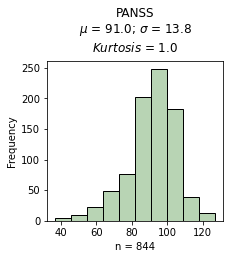

In [44]:
# plotting distribution of panss scores
distribution(df, 'panss', 'PANSS', 'histogram')

Plotting the relationship between PANSS-P and PANSS-N

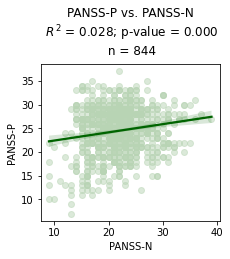

In [45]:
# plotting relationship between postiive and negative symptoms
scatterplot_corr(df, 'panss_ntot', 'panss_ptot', 'PANSS-N', 'PANSS-P', 'PANSS-P vs. PANSS-N', 1)

# 3 – Digital health measures (DHMs)

Here, we are asking basic questions about the DHMs such as their distribution and the effect of age, sex, and visit on their values.

## 3.1 – List of measures
Listing all DHMs that we are using in this analysis

In [46]:
dhms = df.columns[12:25].tolist() + df.columns[30:33].tolist()
for item in dhms:
    print(item.replace('_', ' ').title())

Number Of Turns
Speech Length In Minutes
Speech Length In Words
Speech Percentage
Mean Turn Length In Minutes
Mean Turn Length In Words
Number Of One Word Turns
Words Per Minute
Syllables Per Minute
Word Pause Length Mean
Word Pause Variability
Phrase Pause Length Mean
Phrase Pause Variability
Positive Sentiment
Negative Sentiment
Lexical Richness


## 3.2 – Distributions
Looking at the distribution of values for each DHM

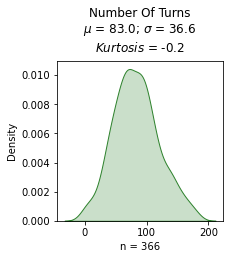

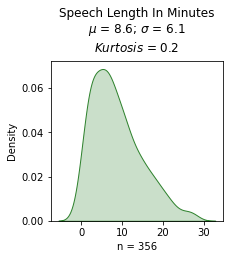

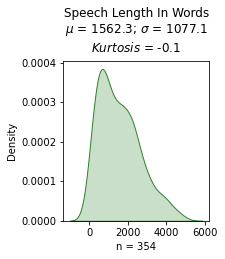

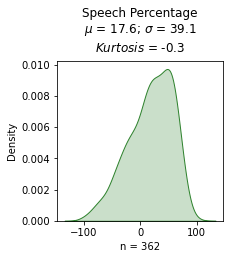

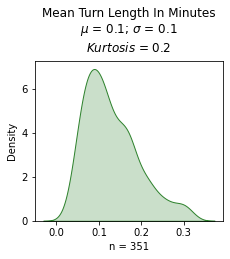

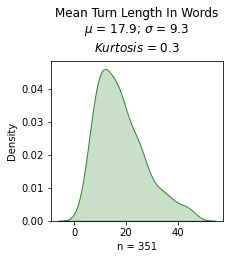

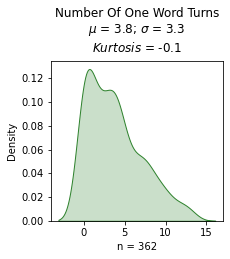

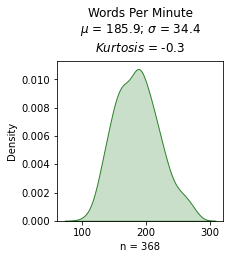

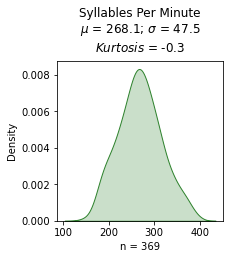

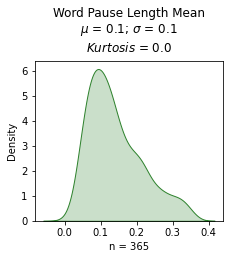

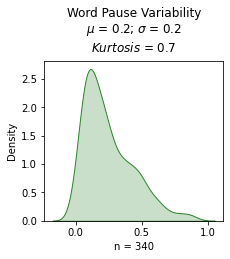

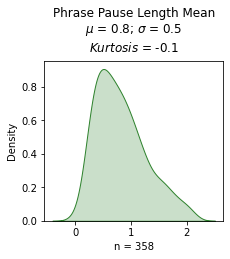

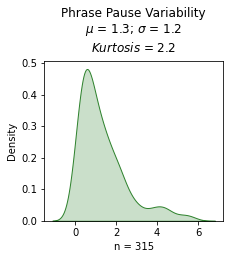

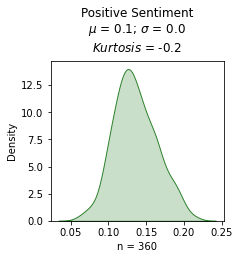

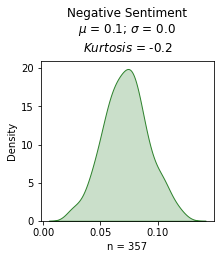

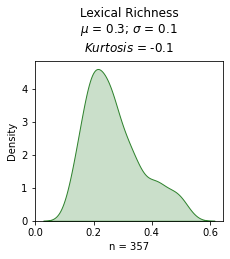

In [47]:
for dhm in dhms:
    distribution(df, dhm, dhm.replace('_', ' ').title(), 'density plot')

## 3.3 – Effect of demographics

### 3.3.1 – Age
Effect of age on each DHM

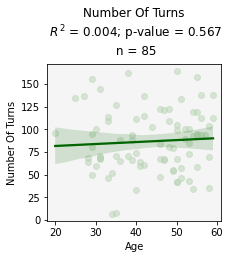

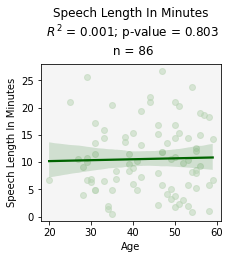

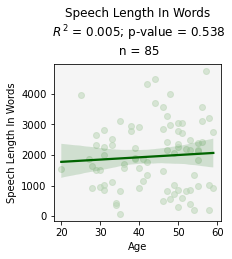

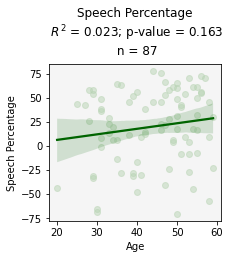

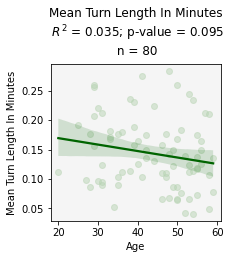

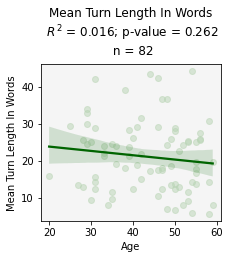

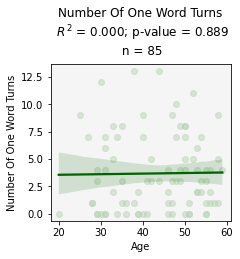

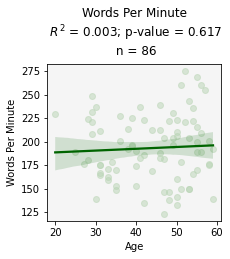

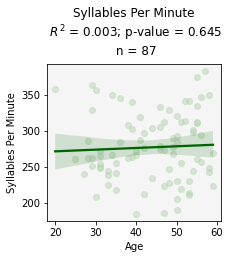

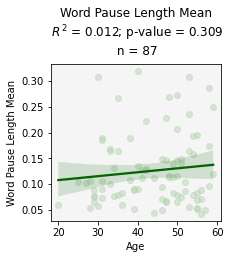

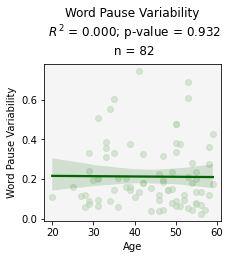

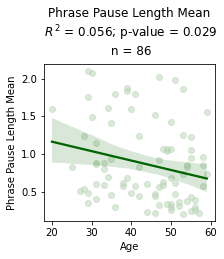

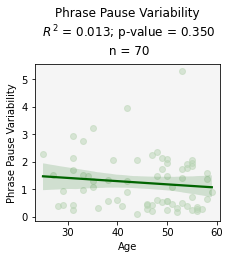

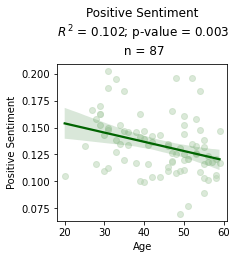

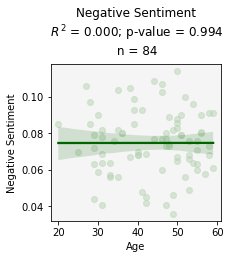

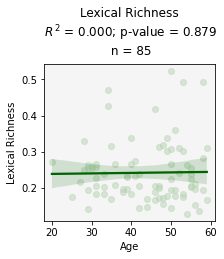

In [48]:
for dhm in dhms:
    dhm_name = dhm.replace("_", " ").title()
    scatterplot_corr(df_screening, 'age', dhm, 'Age', dhm_name, dhm_name, 1)

### 3.3.2 – Sex
Differences in each DHM by sex

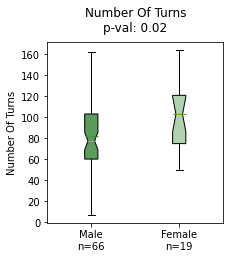

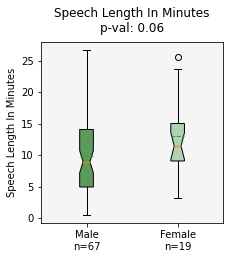

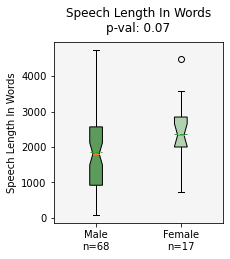

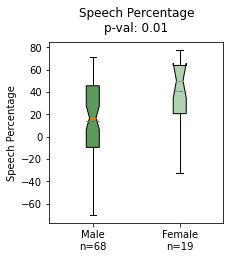

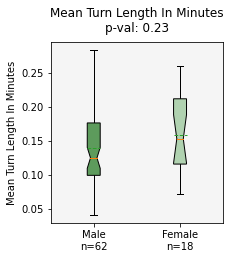

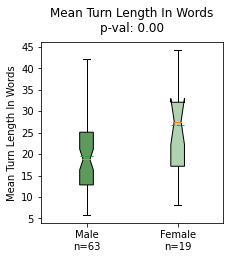

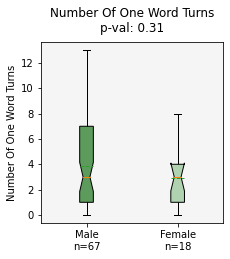

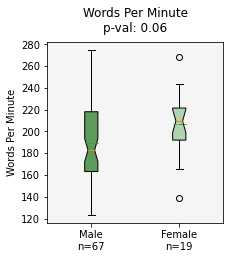

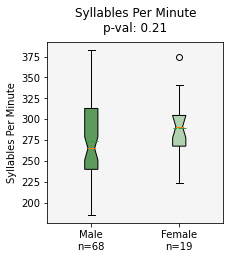

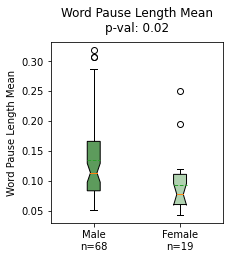

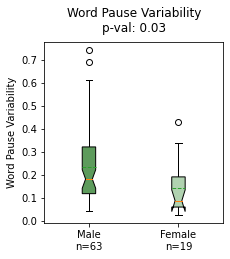

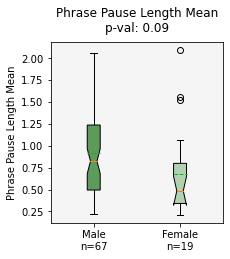

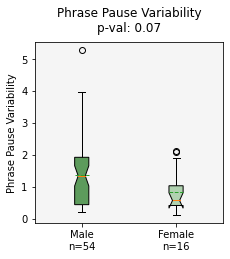

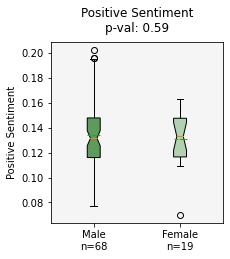

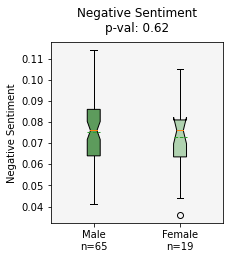

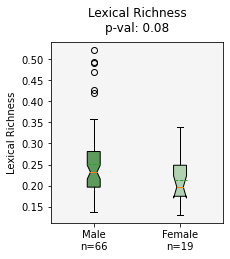

In [49]:
for dhm in dhms:
    
    # define groups
    male = df_screening[df_screening['male'] == 1][dhm].dropna()
    female = df_screening[df_screening['female'] == 1][dhm].dropna()
    
    # plot boxplot
    boxplot_ttest(df_screening, dhm.replace('_', ' ').title(), male, female, 'Male', 'Female', 1)

### 3.3.3 – Race
Differences in each DHM by race

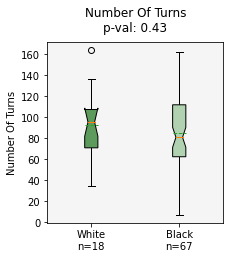

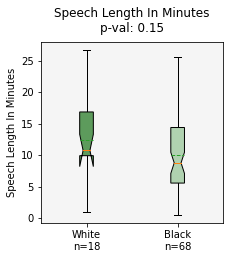

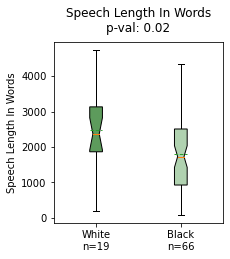

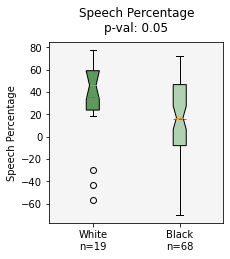

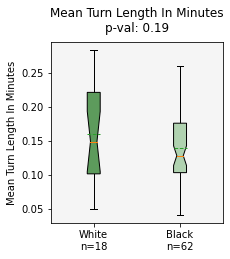

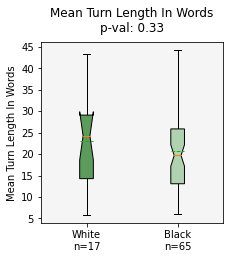

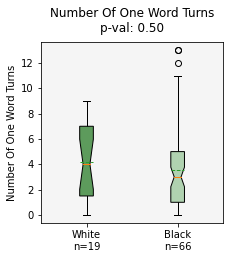

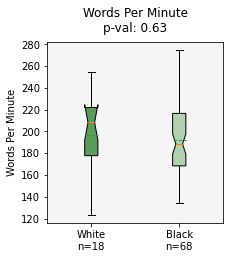

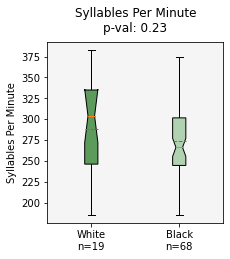

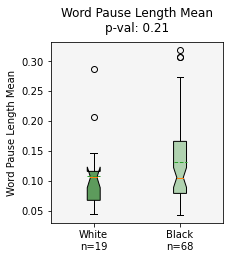

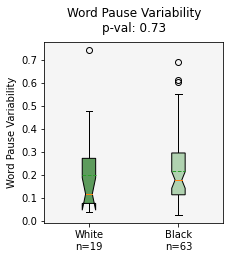

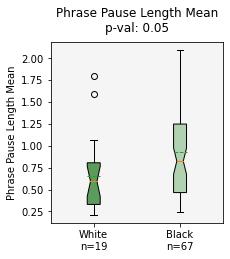

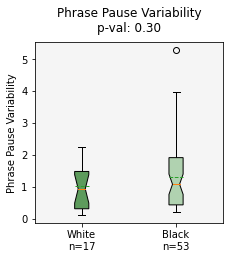

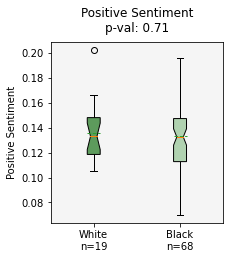

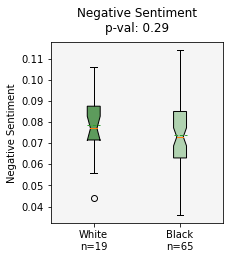

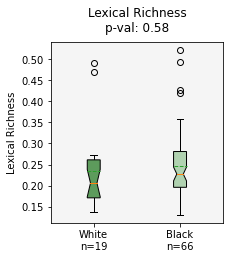

In [50]:
for dhm in dhms:
    
    # define groups
    white = df_screening[df_screening['white'] == 1][dhm].dropna()
    black = df_screening[df_screening['black'] == 1][dhm].dropna()
    
    # plot boxplot
    boxplot_ttest(df_screening, dhm.replace('_', ' ').title(), white, black, 'White', 'Black', 1)

# 4 – Use in recruitment / pre-screening
In this section, we evaluate the potential use of digital health measures in participant recruitment and pre-screening. The objective of this analysis is to assess if speech characteristics correlate with disease severity and if they could potentially be used to identify individuals most likely to pass screening. Hypothetically, these measures could be calculated from recordings of pre-screening phone calls conducted by non-clinicians or through online self-assessments tools. Measures calculated from those interactions could then inform whether an individual is called for an in-person screening visit, improving trial operations.

In [51]:
# creating a dataframe that has averaged data from the screening and baseline visits
df_prerand = df[df['visit'].isin([1, 2])].groupby('id').agg({col: 'first' if i <= 6 else 'mean' for i, col in enumerate(df.columns)})

## 4.1 – Correlation with PANSS
Here, we are going to plot the relationship between each DHM and the PANSS score as well as the positive and negative sub-scale of the PANSS.

### 4.1.1 – All timepoints (repeated measures)

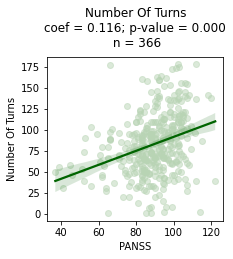

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     10.39
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           5.67e-08
Time:                        15:10:45   Log-Likelihood:                -1449.7
No. Observations:                 366   AIC:                             2909.
Df Residuals:                     361   BIC:                             2929.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              41.6044      1.754     

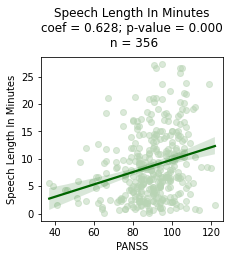

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     7.712
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           5.76e-06
Time:                        15:10:46   Log-Likelihood:                -1421.6
No. Observations:                 356   AIC:                             2853.
Df Residuals:                     351   BIC:                             2873.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

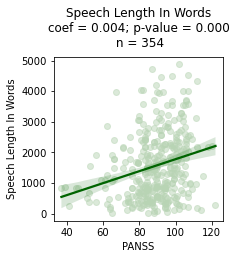

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     7.470
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           8.78e-06
Time:                        15:10:46   Log-Likelihood:                -1412.5
No. Observations:                 354   AIC:                             2835.
Df Residuals:                     349   BIC:                             2854.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     43

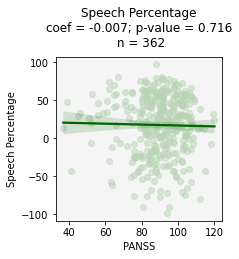

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.5774
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.679
Time:                        15:10:46   Log-Likelihood:                -1451.5
No. Observations:                 362   AIC:                             2913.
Df Residuals:                     357   BIC:                             2932.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                46.2576      1.67

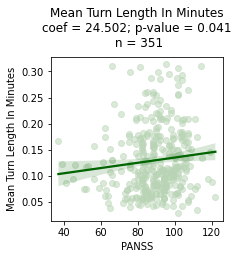

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.750
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.139
Time:                        15:10:47   Log-Likelihood:                -1415.1
No. Observations:                 351   AIC:                             2840.
Df Residuals:                     346   BIC:                             2860.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

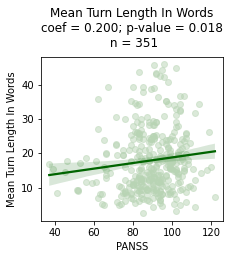

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.138
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0757
Time:                        15:10:47   Log-Likelihood:                -1414.2
No. Observations:                 351   AIC:                             2838.
Df Residuals:                     346   BIC:                             2858.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

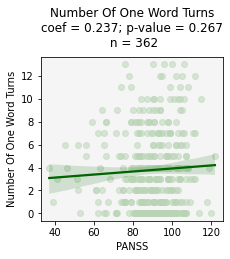

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.7610
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.551
Time:                        15:10:47   Log-Likelihood:                -1454.6
No. Observations:                 362   AIC:                             2919.
Df Residuals:                     357   BIC:                             2939.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

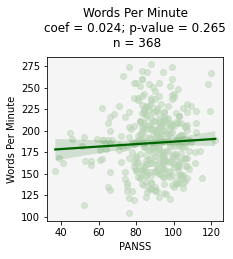

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8668
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.484
Time:                        15:10:48   Log-Likelihood:                -1479.8
No. Observations:                 368   AIC:                             2970.
Df Residuals:                     363   BIC:                             2989.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               44.2515      2.596  

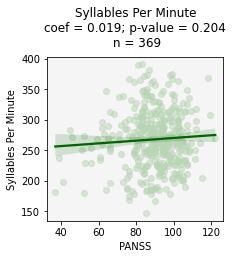

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.009
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.403
Time:                        15:10:48   Log-Likelihood:                -1480.6
No. Observations:                 369   AIC:                             2971.
Df Residuals:                     364   BIC:                             2991.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   43.8703 

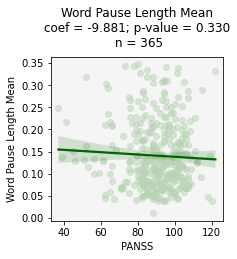

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.7727
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.544
Time:                        15:10:48   Log-Likelihood:                -1467.8
No. Observations:                 365   AIC:                             2946.
Df Residuals:                     360   BIC:                             2965.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     47

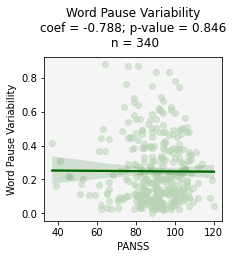

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.4628
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.763
Time:                        15:10:49   Log-Likelihood:                -1363.0
No. Observations:                 340   AIC:                             2736.
Df Residuals:                     335   BIC:                             2755.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     46

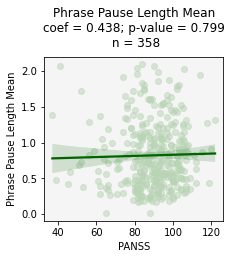

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.7295
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.572
Time:                        15:10:49   Log-Likelihood:                -1440.7
No. Observations:                 358   AIC:                             2891.
Df Residuals:                     353   BIC:                             2911.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

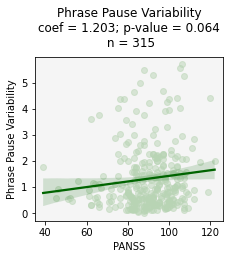

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.682
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.154
Time:                        15:10:49   Log-Likelihood:                -1249.6
No. Observations:                 315   AIC:                             2509.
Df Residuals:                     310   BIC:                             2528.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

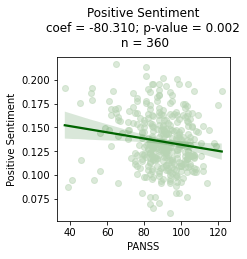

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2.970
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0196
Time:                        15:10:50   Log-Likelihood:                -1441.4
No. Observations:                 360   AIC:                             2893.
Df Residuals:                     355   BIC:                             2912.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 52.4770      2

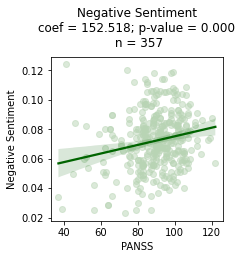

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     5.029
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           0.000594
Time:                        15:10:50   Log-Likelihood:                -1427.4
No. Observations:                 357   AIC:                             2865.
Df Residuals:                     352   BIC:                             2884.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 40.6586      2

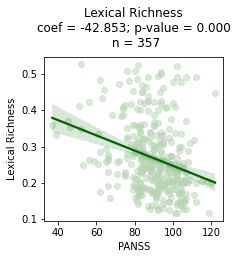

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     9.488
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           2.70e-07
Time:                        15:10:50   Log-Likelihood:                -1411.4
No. Observations:                 357   AIC:                             2833.
Df Residuals:                     352   BIC:                             2852.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               51.6225      1.860  

In [52]:
for dhm in dhms:
    scatterplot_mlr(df, 'panss', dhm, 'PANSS', dhm.replace("_", " ").title(), 1)

### 4.1.2 – Screening and baseline, averaged

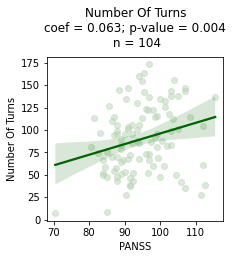

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     2.213
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0730
Time:                        15:10:51   Log-Likelihood:                -360.42
No. Observations:                 104   AIC:                             730.8
Df Residuals:                      99   BIC:                             744.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              44.1811      1.995     

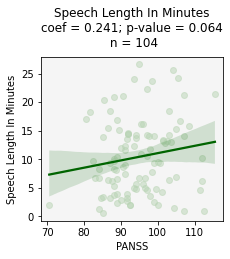

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.009
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.406
Time:                        15:10:51   Log-Likelihood:                -363.16
No. Observations:                 104   AIC:                             736.3
Df Residuals:                      99   BIC:                             749.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

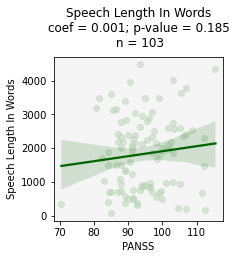

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.6757
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.610
Time:                        15:10:51   Log-Likelihood:                -360.58
No. Observations:                 103   AIC:                             731.2
Df Residuals:                      98   BIC:                             744.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     45

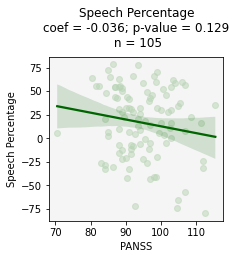

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.6932
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.598
Time:                        15:10:52   Log-Likelihood:                -367.35
No. Observations:                 105   AIC:                             744.7
Df Residuals:                     100   BIC:                             758.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                47.0664      1.79

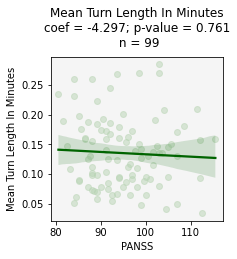

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.2852
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.887
Time:                        15:10:52   Log-Likelihood:                -344.10
No. Observations:                  99   AIC:                             698.2
Df Residuals:                      94   BIC:                             711.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

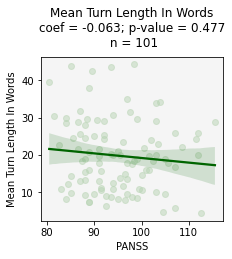

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.4320
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.785
Time:                        15:10:52   Log-Likelihood:                -350.02
No. Observations:                 101   AIC:                             710.0
Df Residuals:                      96   BIC:                             723.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

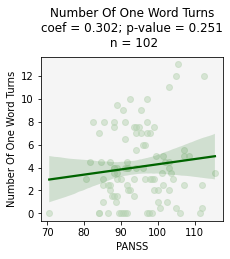

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.4575
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.767
Time:                        15:10:53   Log-Likelihood:                -357.02
No. Observations:                 102   AIC:                             724.0
Df Residuals:                      97   BIC:                             737.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

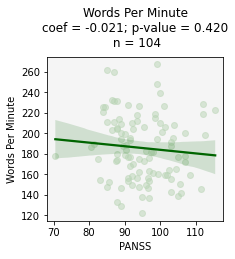

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                    0.2756
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.893
Time:                        15:10:53   Log-Likelihood:                -364.31
No. Observations:                 104   AIC:                             738.6
Df Residuals:                      99   BIC:                             751.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               49.2964      3.026  

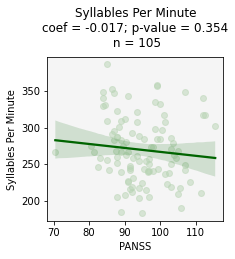

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.3210
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.863
Time:                        15:10:53   Log-Likelihood:                -368.11
No. Observations:                 105   AIC:                             746.2
Df Residuals:                     100   BIC:                             759.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   49.3830 

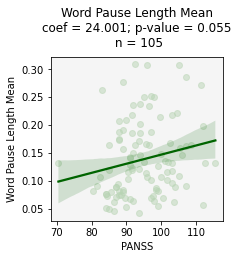

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.051
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.385
Time:                        15:10:54   Log-Likelihood:                -366.62
No. Observations:                 105   AIC:                             743.2
Df Residuals:                     100   BIC:                             756.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     45

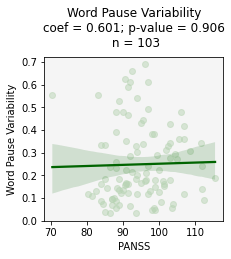

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                    0.1087
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.979
Time:                        15:10:54   Log-Likelihood:                -361.47
No. Observations:                 103   AIC:                             732.9
Df Residuals:                      98   BIC:                             746.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     46

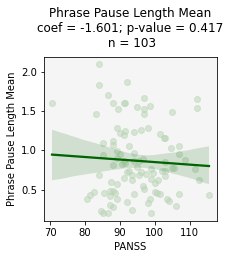

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                    0.2904
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.884
Time:                        15:10:54   Log-Likelihood:                -361.93
No. Observations:                 103   AIC:                             733.9
Df Residuals:                      98   BIC:                             747.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

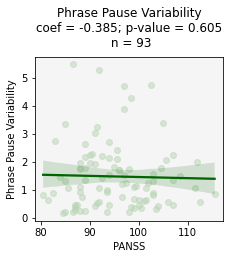

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.035
Method:                 Least Squares   F-statistic:                    0.2132
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.930
Time:                        15:10:55   Log-Likelihood:                -321.99
No. Observations:                  93   AIC:                             654.0
Df Residuals:                      88   BIC:                             666.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

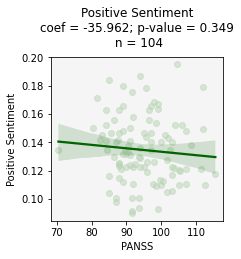

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.3143
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.868
Time:                        15:10:55   Log-Likelihood:                -365.07
No. Observations:                 104   AIC:                             740.1
Df Residuals:                      99   BIC:                             753.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 50.1597      3

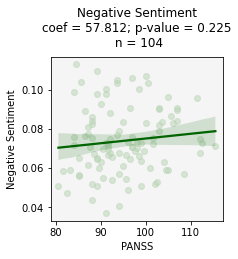

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.5786
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.679
Time:                        15:10:55   Log-Likelihood:                -359.91
No. Observations:                 104   AIC:                             729.8
Df Residuals:                      99   BIC:                             743.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 45.4011      2

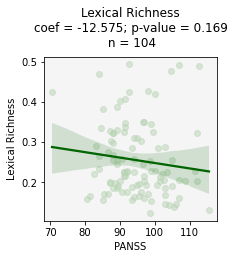

                            OLS Regression Results                            
Dep. Variable:                  panss   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.6139
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.654
Time:                        15:10:56   Log-Likelihood:                -363.77
No. Observations:                 104   AIC:                             737.5
Df Residuals:                      99   BIC:                             750.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               48.9372      2.180  

In [53]:
for dhm in dhms:
    scatterplot_mlr(df_prerand, 'panss', dhm, 'PANSS', dhm.replace("_", " ").title(), 1)

## 4.2 – Correlation with PANSS-P

### 4.2.1 – All timepoints (repeated measures)

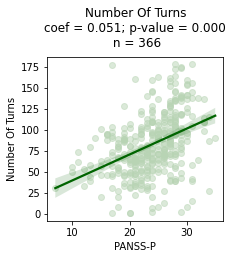

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     18.41
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           8.79e-14
Time:                        15:10:56   Log-Likelihood:                -1058.0
No. Observations:                 366   AIC:                             2126.
Df Residuals:                     361   BIC:                             2146.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              10.2686      0.602     

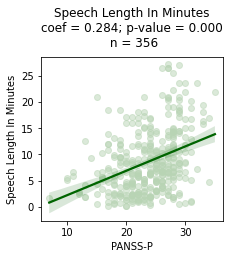

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     14.48
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           5.95e-11
Time:                        15:10:56   Log-Likelihood:                -1030.9
No. Observations:                 356   AIC:                             2072.
Df Residuals:                     351   BIC:                             2091.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

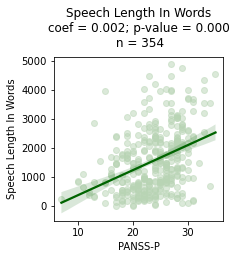

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     15.40
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           1.32e-11
Time:                        15:10:57   Log-Likelihood:                -1023.8
No. Observations:                 354   AIC:                             2058.
Df Residuals:                     349   BIC:                             2077.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     10

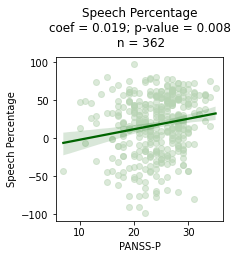

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     3.535
Date:                Tue, 09 Apr 2024   Prob (F-statistic):            0.00761
Time:                        15:10:57   Log-Likelihood:                -1074.2
No. Observations:                 362   AIC:                             2158.
Df Residuals:                     357   BIC:                             2178.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.4801      0.59

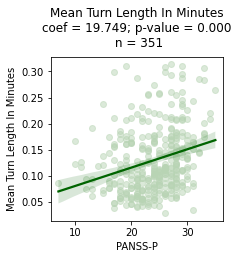

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     7.806
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           4.94e-06
Time:                        15:10:57   Log-Likelihood:                -1037.4
No. Observations:                 351   AIC:                             2085.
Df Residuals:                     346   BIC:                             2104.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

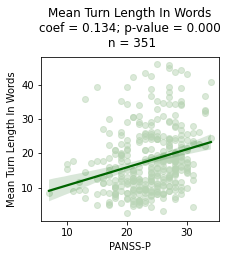

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     7.126
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           1.60e-05
Time:                        15:10:58   Log-Likelihood:                -1031.5
No. Observations:                 351   AIC:                             2073.
Df Residuals:                     346   BIC:                             2092.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

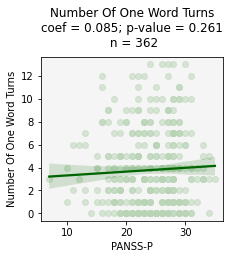

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.097
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0807
Time:                        15:10:58   Log-Likelihood:                -1078.7
No. Observations:                 362   AIC:                             2167.
Df Residuals:                     357   BIC:                             2187.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

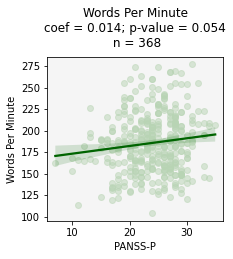

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.803
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0257
Time:                        15:10:58   Log-Likelihood:                -1094.0
No. Observations:                 368   AIC:                             2198.
Df Residuals:                     363   BIC:                             2217.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               11.0775      0.910  

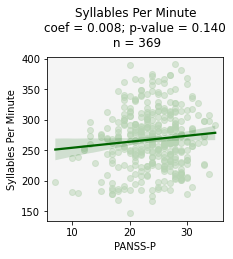

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2.468
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0445
Time:                        15:10:59   Log-Likelihood:                -1096.7
No. Observations:                 369   AIC:                             2203.
Df Residuals:                     364   BIC:                             2223.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.3508 

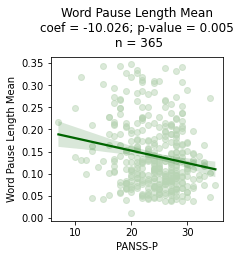

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3.748
Date:                Tue, 09 Apr 2024   Prob (F-statistic):            0.00530
Time:                        15:10:59   Log-Likelihood:                -1082.3
No. Observations:                 365   AIC:                             2175.
Df Residuals:                     360   BIC:                             2194.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     12

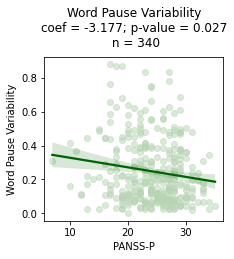

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.725
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0294
Time:                        15:10:59   Log-Likelihood:                -1010.0
No. Observations:                 340   AIC:                             2030.
Df Residuals:                     335   BIC:                             2049.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     12

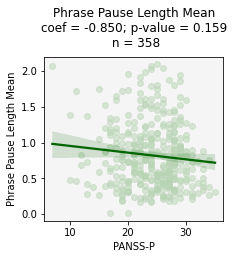

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.228
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0656
Time:                        15:11:00   Log-Likelihood:                -1065.6
No. Observations:                 358   AIC:                             2141.
Df Residuals:                     353   BIC:                             2161.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

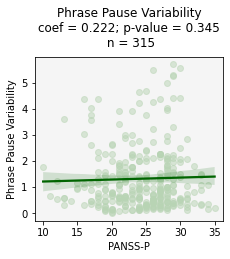

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.301
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.270
Time:                        15:11:00   Log-Likelihood:                -931.65
No. Observations:                 315   AIC:                             1873.
Df Residuals:                     310   BIC:                             1892.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

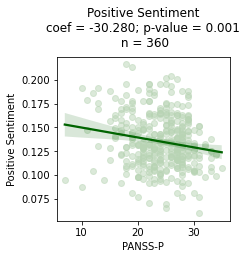

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     4.552
Date:                Tue, 09 Apr 2024   Prob (F-statistic):            0.00135
Time:                        15:11:00   Log-Likelihood:                -1065.0
No. Observations:                 360   AIC:                             2140.
Df Residuals:                     355   BIC:                             2159.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 14.8573      0

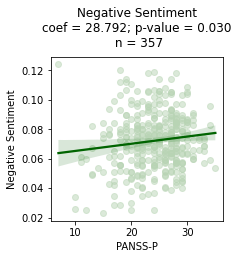

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.640
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0337
Time:                        15:11:01   Log-Likelihood:                -1062.3
No. Observations:                 357   AIC:                             2135.
Df Residuals:                     352   BIC:                             2154.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 11.2875      0

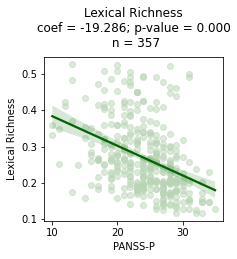

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     17.16
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           7.22e-13
Time:                        15:11:01   Log-Likelihood:                -1027.1
No. Observations:                 357   AIC:                             2064.
Df Residuals:                     352   BIC:                             2084.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               14.9677      0.634  

In [54]:
for dhm in dhms:
    scatterplot_mlr(df, 'panss_ptot', dhm, 'PANSS-P', dhm.replace("_", " ").title(), 1)

### 4.2.2 – Screening and baseline, averaged

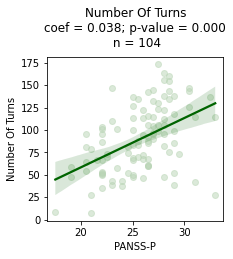

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     7.394
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           2.97e-05
Time:                        15:11:01   Log-Likelihood:                -253.69
No. Observations:                 104   AIC:                             517.4
Df Residuals:                      99   BIC:                             530.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              11.0873      0.715     

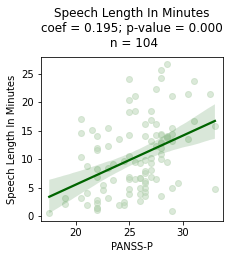

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     5.460
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           0.000516
Time:                        15:11:02   Log-Likelihood:                -256.02
No. Observations:                 104   AIC:                             522.0
Df Residuals:                      99   BIC:                             535.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

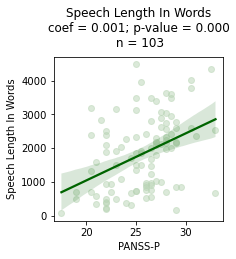

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     4.963
Date:                Tue, 09 Apr 2024   Prob (F-statistic):            0.00110
Time:                        15:11:02   Log-Likelihood:                -254.29
No. Observations:                 103   AIC:                             518.6
Df Residuals:                      98   BIC:                             531.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     11

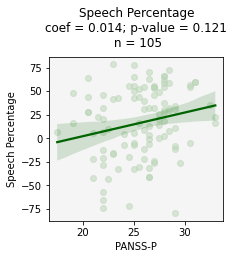

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.615
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.176
Time:                        15:11:02   Log-Likelihood:                -266.33
No. Observations:                 105   AIC:                             542.7
Df Residuals:                     100   BIC:                             555.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.8292      0.68

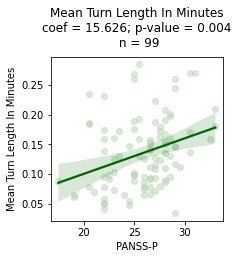

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     2.933
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0247
Time:                        15:11:03   Log-Likelihood:                -246.60
No. Observations:                  99   AIC:                             503.2
Df Residuals:                      94   BIC:                             516.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

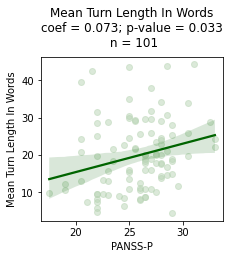

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     1.775
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.140
Time:                        15:11:03   Log-Likelihood:                -253.91
No. Observations:                 101   AIC:                             517.8
Df Residuals:                      96   BIC:                             530.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

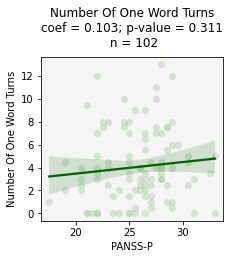

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.154
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.336
Time:                        15:11:03   Log-Likelihood:                -260.26
No. Observations:                 102   AIC:                             530.5
Df Residuals:                      97   BIC:                             543.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

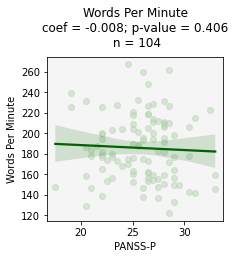

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.361
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.253
Time:                        15:11:04   Log-Likelihood:                -264.07
No. Observations:                 104   AIC:                             538.1
Df Residuals:                      99   BIC:                             551.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.7261      1.154  

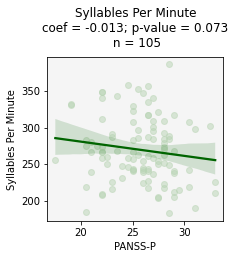

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.833
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.128
Time:                        15:11:04   Log-Likelihood:                -265.90
No. Observations:                 105   AIC:                             541.8
Df Residuals:                     100   BIC:                             555.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   14.5523 

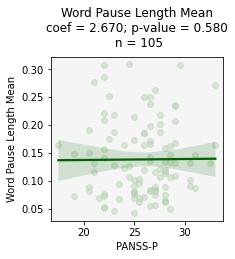

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.059
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.381
Time:                        15:11:04   Log-Likelihood:                -267.44
No. Observations:                 105   AIC:                             544.9
Df Residuals:                     100   BIC:                             558.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     12

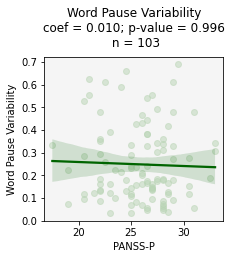

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.8220
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.514
Time:                        15:11:05   Log-Likelihood:                -261.93
No. Observations:                 103   AIC:                             533.9
Df Residuals:                      98   BIC:                             547.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     12

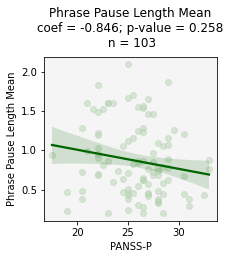

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.203
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.315
Time:                        15:11:05   Log-Likelihood:                -261.73
No. Observations:                 103   AIC:                             533.5
Df Residuals:                      98   BIC:                             546.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

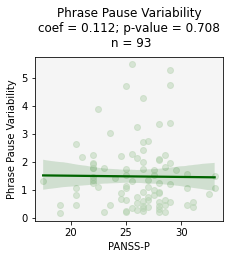

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.6585
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.622
Time:                        15:11:05   Log-Likelihood:                -237.41
No. Observations:                  93   AIC:                             484.8
Df Residuals:                      88   BIC:                             497.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

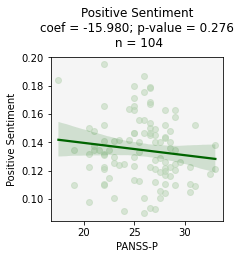

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.295
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.277
Time:                        15:11:06   Log-Likelihood:                -264.82
No. Observations:                 104   AIC:                             539.6
Df Residuals:                      99   BIC:                             552.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 14.2354      1

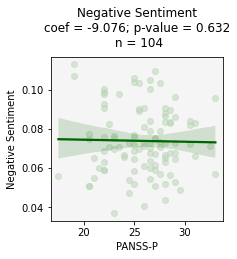

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9353
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.447
Time:                        15:11:06   Log-Likelihood:                -264.49
No. Observations:                 104   AIC:                             539.0
Df Residuals:                      99   BIC:                             552.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 13.2487      0

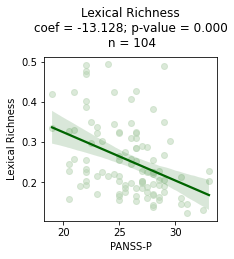

                            OLS Regression Results                            
Dep. Variable:             panss_ptot   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     5.308
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           0.000648
Time:                        15:11:06   Log-Likelihood:                -253.94
No. Observations:                 104   AIC:                             517.9
Df Residuals:                      99   BIC:                             531.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               14.7560      0.758  

In [55]:
for dhm in dhms:
    scatterplot_mlr(df_prerand, 'panss_ptot', dhm, 'PANSS-P', dhm.replace("_", " ").title(), 1)

## 4.3 – Correlation with PANSS-N

### 4.3.1 – All timepoints (repeated measures)

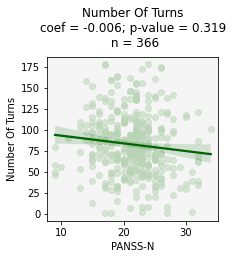

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     9.228
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           4.15e-07
Time:                        15:11:07   Log-Likelihood:                -1034.1
No. Observations:                 366   AIC:                             2078.
Df Residuals:                     361   BIC:                             2098.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              11.5917      0.564     

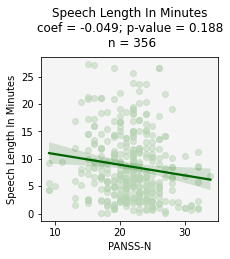

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     8.269
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           2.20e-06
Time:                        15:11:07   Log-Likelihood:                -1005.7
No. Observations:                 356   AIC:                             2021.
Df Residuals:                     351   BIC:                             2041.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

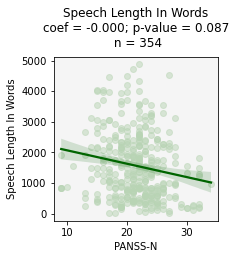

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     8.736
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           9.91e-07
Time:                        15:11:07   Log-Likelihood:                -998.78
No. Observations:                 354   AIC:                             2008.
Df Residuals:                     349   BIC:                             2027.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     11

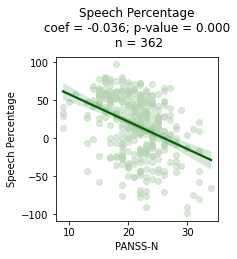

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     18.62
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           6.51e-14
Time:                        15:11:08   Log-Likelihood:                -1000.8
No. Observations:                 362   AIC:                             2012.
Df Residuals:                     357   BIC:                             2031.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.1076      0.48

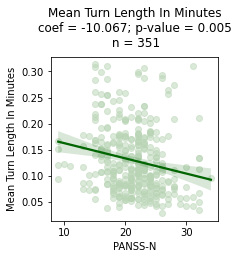

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     10.16
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           8.73e-08
Time:                        15:11:08   Log-Likelihood:                -991.82
No. Observations:                 351   AIC:                             1994.
Df Residuals:                     346   BIC:                             2013.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

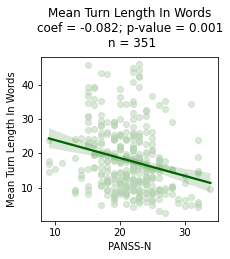

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     11.40
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           1.05e-08
Time:                        15:11:08   Log-Likelihood:                -987.24
No. Observations:                 351   AIC:                             1984.
Df Residuals:                     346   BIC:                             2004.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

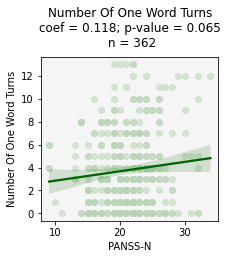

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     9.614
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           2.15e-07
Time:                        15:11:09   Log-Likelihood:                -1016.1
No. Observations:                 362   AIC:                             2042.
Df Residuals:                     357   BIC:                             2062.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

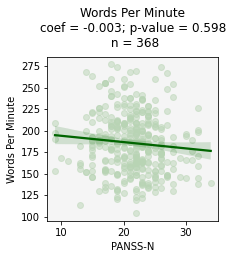

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     9.338
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           3.41e-07
Time:                        15:11:09   Log-Likelihood:                -1040.4
No. Observations:                 368   AIC:                             2091.
Df Residuals:                     363   BIC:                             2110.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               11.6749      0.787  

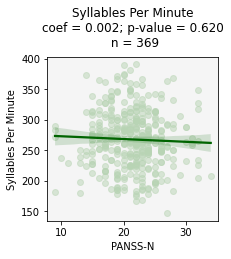

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     9.281
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           3.76e-07
Time:                        15:11:09   Log-Likelihood:                -1042.4
No. Observations:                 369   AIC:                             2095.
Df Residuals:                     364   BIC:                             2114.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.0460 

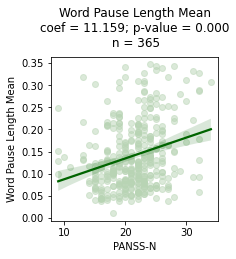

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     12.97
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           7.13e-10
Time:                        15:11:10   Log-Likelihood:                -1026.7
No. Observations:                 365   AIC:                             2063.
Df Residuals:                     360   BIC:                             2083.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     10

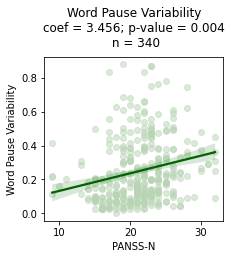

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     10.10
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           9.97e-08
Time:                        15:11:10   Log-Likelihood:                -947.27
No. Observations:                 340   AIC:                             1905.
Df Residuals:                     335   BIC:                             1924.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     10

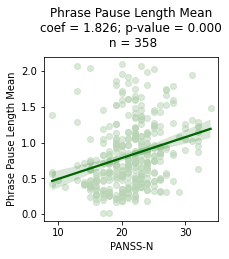

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     12.35
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           2.08e-09
Time:                        15:11:10   Log-Likelihood:                -1006.4
No. Observations:                 358   AIC:                             2023.
Df Residuals:                     353   BIC:                             2042.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

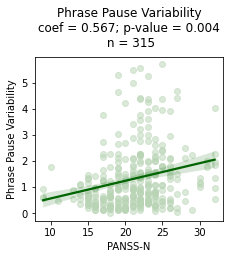

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     13.01
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           8.36e-10
Time:                        15:11:11   Log-Likelihood:                -875.14
No. Observations:                 315   AIC:                             1760.
Df Residuals:                     310   BIC:                             1779.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

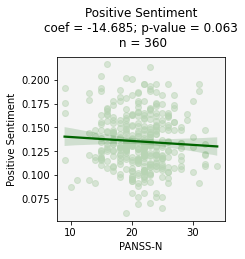

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     9.560
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           2.37e-07
Time:                        15:11:11   Log-Likelihood:                -1015.4
No. Observations:                 360   AIC:                             2041.
Df Residuals:                     355   BIC:                             2060.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.3019      0

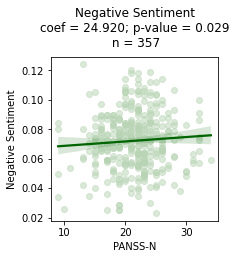

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     10.19
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           8.13e-08
Time:                        15:11:11   Log-Likelihood:                -1008.9
No. Observations:                 357   AIC:                             2028.
Df Residuals:                     352   BIC:                             2047.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 10.3820      0

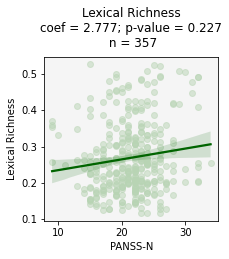

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     9.675
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           1.96e-07
Time:                        15:11:12   Log-Likelihood:                -1003.7
No. Observations:                 357   AIC:                             2017.
Df Residuals:                     352   BIC:                             2037.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               10.6794      0.594  

In [56]:
for dhm in dhms:
    scatterplot_mlr(df, 'panss_ntot', dhm, 'PANSS-N', dhm.replace("_", " ").title(), 1)

### 4.3.2 – Screening and baseline, averaged

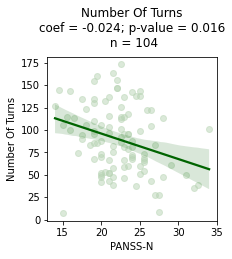

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     4.270
Date:                Tue, 09 Apr 2024   Prob (F-statistic):            0.00314
Time:                        15:11:12   Log-Likelihood:                -278.90
No. Observations:                 104   AIC:                             567.8
Df Residuals:                      99   BIC:                             581.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              11.8664      0.911     

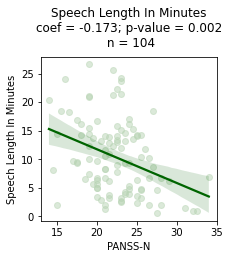

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     5.048
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           0.000960
Time:                        15:11:12   Log-Likelihood:                -276.18
No. Observations:                 104   AIC:                             562.4
Df Residuals:                      99   BIC:                             575.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

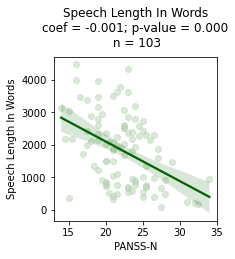

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     7.242
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           3.76e-05
Time:                        15:11:13   Log-Likelihood:                -271.57
No. Observations:                 103   AIC:                             553.1
Df Residuals:                      98   BIC:                             566.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     11

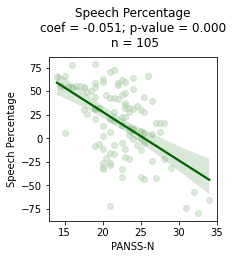

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     10.76
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           2.69e-07
Time:                        15:11:13   Log-Likelihood:                -270.65
No. Observations:                 105   AIC:                             551.3
Df Residuals:                     100   BIC:                             564.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                10.7875      0.71

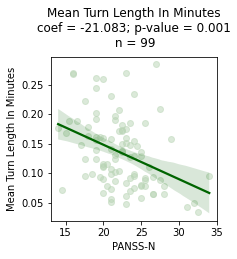

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     5.929
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           0.000268
Time:                        15:11:13   Log-Likelihood:                -261.45
No. Observations:                  99   AIC:                             532.9
Df Residuals:                      94   BIC:                             545.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

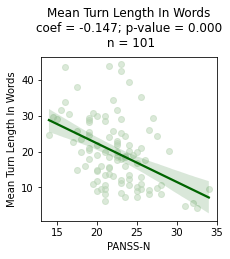

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     6.944
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           5.93e-05
Time:                        15:11:14   Log-Likelihood:                -264.65
No. Observations:                 101   AIC:                             539.3
Df Residuals:                      96   BIC:                             552.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

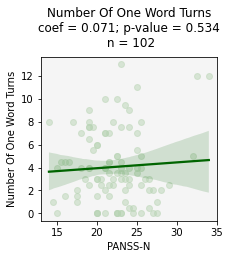

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     2.939
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0243
Time:                        15:11:14   Log-Likelihood:                -272.89
No. Observations:                 102   AIC:                             555.8
Df Residuals:                      97   BIC:                             568.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

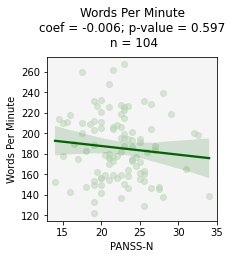

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     2.685
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0357
Time:                        15:11:14   Log-Likelihood:                -281.78
No. Observations:                 104   AIC:                             573.6
Df Residuals:                      99   BIC:                             586.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               11.3459      1.368  

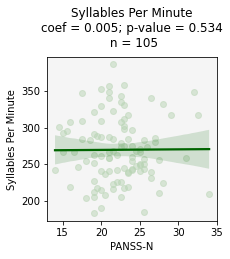

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     2.769
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0313
Time:                        15:11:15   Log-Likelihood:                -283.94
No. Observations:                 105   AIC:                             577.9
Df Residuals:                     100   BIC:                             591.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.0653 

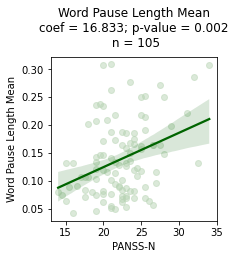

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     5.375
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           0.000581
Time:                        15:11:15   Log-Likelihood:                -279.23
No. Observations:                 105   AIC:                             568.5
Df Residuals:                     100   BIC:                             581.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      9

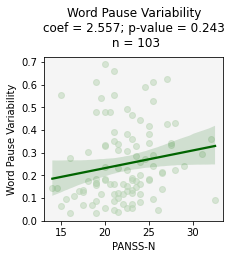

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2.839
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0283
Time:                        15:11:15   Log-Likelihood:                -274.26
No. Observations:                 103   AIC:                             558.5
Df Residuals:                      98   BIC:                             571.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     10

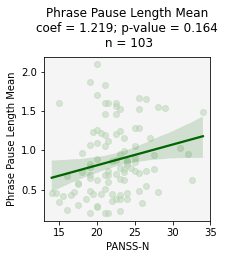

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     3.006
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0219
Time:                        15:11:16   Log-Likelihood:                -278.00
No. Observations:                 103   AIC:                             566.0
Df Residuals:                      98   BIC:                             579.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

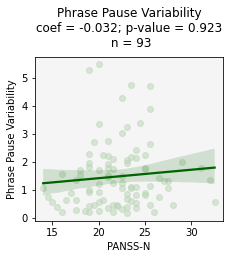

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     2.852
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0283
Time:                        15:11:16   Log-Likelihood:                -246.86
No. Observations:                  93   AIC:                             503.7
Df Residuals:                      88   BIC:                             516.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

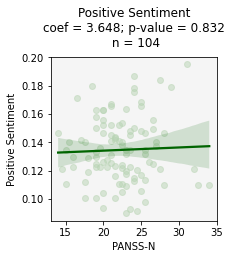

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     2.623
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0393
Time:                        15:11:16   Log-Likelihood:                -281.90
No. Observations:                 104   AIC:                             573.8
Df Residuals:                      99   BIC:                             587.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 10.4659      1

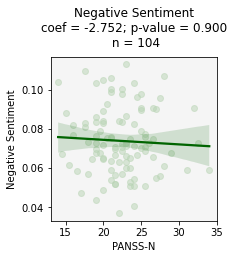

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     3.051
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0204
Time:                        15:11:17   Log-Likelihood:                -279.31
No. Observations:                 104   AIC:                             568.6
Df Residuals:                      99   BIC:                             581.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 11.0241      1

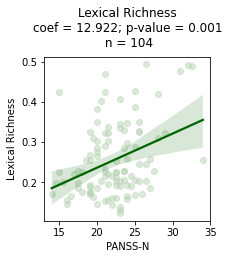

                            OLS Regression Results                            
Dep. Variable:             panss_ntot   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     5.558
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           0.000445
Time:                        15:11:17   Log-Likelihood:                -275.70
No. Observations:                 104   AIC:                             561.4
Df Residuals:                      99   BIC:                             574.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.9313      0.935  

In [57]:
for dhm in dhms:
    scatterplot_mlr(df_prerand, 'panss_ntot', dhm, 'PANSS-N', dhm.replace("_", " ").title(), 1)